### Load Libraries
#### Pytorch Lightning, HuggingFace Bert, Pandas, SKLearn

In [1]:


import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc
from tqdm.auto import tqdm
import re
from tqdm import tqdm

from transformers import BertTokenizerFast as BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
from torchmetrics.functional import auroc

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, multilabel_confusion_matrix, accuracy_score, precision_score, recall_score, f1_score



RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)



### Data Collection

In [2]:
##Read in the dataset
toxiccomments_df = pd.read_csv("toxic_comments.csv")


### Text to Numeric Representation

In [4]:
##This method is a batch method to load the augmented data files
import re

def process_file_to_dataframe(file_path):
    # Regular expression to match lines with six comma-separated integers (either 0 or 1) at the end
    pattern = re.compile(r"(.*),(0|1),\s*(0|1),\s*(0|1),\s*(0|1),\s*(0|1),\s*(0|1)$")

    # Preparing a list to store each row as a dictionary
    data = []

    # Reading the file and processing each line
    try:
        with open(file_path, 'r', encoding='utf-8') as file:
            for line in file:
                match = pattern.search(line)
                if match:
                    # Creating a dictionary for each matched line
                    row = {
                        'comment_text': match.group(1).strip(),
                        'toxic': int(match.group(2)),
                        'severe_toxic': int(match.group(3)),
                        'obscene': int(match.group(4)),
                        'threat': int(match.group(5)),
                        'insult': int(match.group(6)),
                        'identity_hate': int(match.group(7))
                    }
                    data.append(row)
    except UnicodeDecodeError:
        # Try a different encoding in case of a decode error
        with open(file_path, 'r', encoding='ISO-8859-1') as file:
            for line in file:
                match = pattern.search(line)
                if match:
                    # Creating a dictionary for each matched line
                    row = {
                        'comment_text': match.group(1).strip(),
                        'toxic': int(match.group(2)),
                        'severe_toxic': int(match.group(3)),
                        'obscene': int(match.group(4)),
                        'threat': int(match.group(5)),
                        'insult': int(match.group(6)),
                        'identity_hate': int(match.group(7))
                    }
                    data.append(row)

    # Creating a DataFrame from the list of dictionaries
    df = pd.DataFrame(data)

    return df

# Example usage
file_path = 'translated_text_with_labels_fr.txt'   # Replace with your actual file path
augdata_fr = process_file_to_dataframe(file_path)

# Now 'df' is a pandas DataFrame with the specified structure
augdata_fr.insert(0, 'id', 'x')

In [5]:
# Assuming 'other_df' is your other DataFrame
# Append 'df' to 'other_df'
##toxiccomments_df = pd.concat([toxiccomments_df, augdata_ger], ignore_index=True)
##toxiccomments_df = pd.concat([toxiccomments_df, augdata_sp], ignore_index=True)
toxiccomments_df = pd.concat([toxiccomments_df, augdata_fr], ignore_index=True)


### Data Augmentation

See Data Augmentation.ipynb

### Data Preparation

Splitting up Data
Creating Pytorch DataSet Class
Creating Pytorch DataLoader Class


In [14]:
##Split up our data



from sklearn.model_selection import train_test_split

# Initial split: 90% train, 10% temporary (for validation and test)
train_df, temp_df = train_test_split(toxiccomments_df, test_size=0.1)

# Second split of the temporary dataset: 50% validation, 50% test (5% of the original dataset each)
val_df, test_df = train_test_split(temp_df, test_size=0.5)

In [ ]:
# Assuming 'other_df' is your other DataFrame
# Append 'df' to 'other_df'
##toxiccomments_df = pd.concat([toxiccomments_df, augdata_ger], ignore_index=True)
##toxiccomments_df = pd.concat([toxiccomments_df, augdata_sp], ignore_index=True)
toxiccomments_df = pd.concat([toxiccomments_df, augdata_fr], ignore_index=True)
# Now 'appended_df' is the combined DataFrame
print(toxiccomments_df.head())  # 

In [7]:
##Inspect the size of our datasets

train_df.shape, val_df.shape, test_df.shape

((158090, 8), (8783, 8), (8783, 8))

In [6]:
long_strings = toxiccomments_df[toxiccomments_df['comment_text'].str.len() > 128]

# Display the result
print(long_strings.head())

                  id                                       comment_text  \
0   0000997932d777bf  Explanation\nWhy the edits made under my usern...   
2   000113f07ec002fd  Hey man, I'm really not trying to edit war. It...   
3   0001b41b1c6bb37e  "\nMore\nI can't make any real suggestions on ...   
8   00037261f536c51d  Sorry if the word 'nonsense' was offensive to ...   
10  0005300084f90edc  "\nFair use rationale for Image:Wonju.jpg\n\nT...   

    toxic  severe_toxic  obscene  threat  insult  identity_hate  
0       0             0        0       0       0              0  
2       0             0        0       0       0              0  
3       0             0        0       0       0              0  
8       0             0        0       0       0              0  
10      0             0        0       0       0              0  


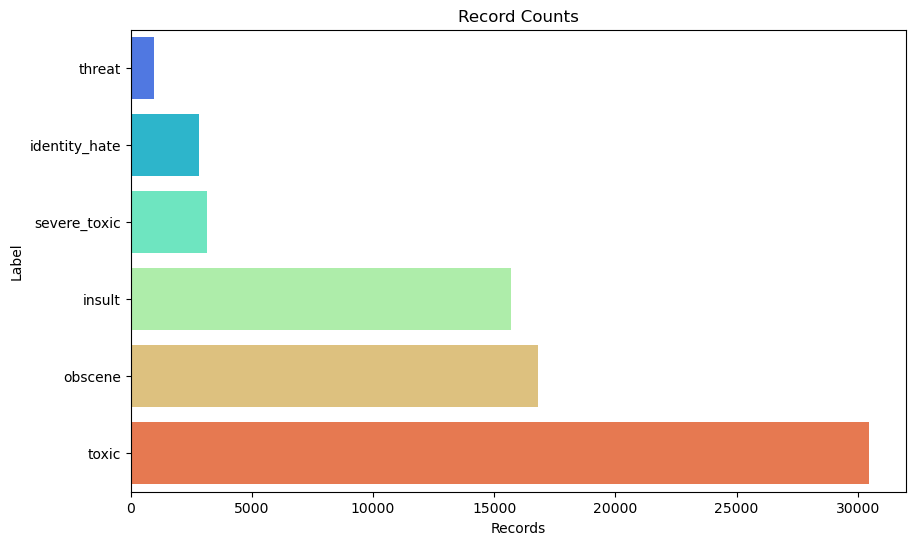

In [15]:
labels_c = toxiccomments_df.columns.tolist()[2:]

summed_data = toxiccomments_df[labels_c].sum().sort_values()

# Getting the colors from the rainbow palette, one for each bar
palette = sns.color_palette("rainbow", len(summed_data))

# Creating the bar plot with individual colors
plt.figure(figsize=(10, 6))
sns.barplot(y=summed_data.index, x=summed_data.values, palette=palette)
plt.title('Record Counts')
plt.xlabel('Records')
plt.ylabel('Label')
plt.show()

In [16]:
train_toxic = train_df[train_df[labels_c].sum(axis=1) > 0]
train_clean = train_df[train_df[labels_c].sum(axis=1) == 0]


train_df = pd.concat([  train_toxic,  train_clean.sample(30000)])


In [17]:
len(train_df)

59110

In [10]:
len(train_toxic)

14650

In [11]:
BERT_MODEL_NAME = 'bert-base-cased'
tokenizer = BertTokenizer.from_pretrained(BERT_MODEL_NAME, return_dict = True)



In [12]:
max_token_count = 512

In [30]:
##Pytorch Dataset Class
##need to define our getitem in our pytorch dataset
##provide parameters in how to load the data

class ToxicCommentsDataset(Dataset):

  def __init__(
    self, 
    data: pd.DataFrame, 
    tokenizer: BertTokenizer, 
    max_token_len: int = 128
  ):
    self.tokenizer = tokenizer
    self.data = data
    self.max_token_len = max_token_len
    
  def __len__(self):
    return len(self.data)

  def __getitem__(self, index: int):
    
    ##gets a single row
    data_row = self.data.iloc[index]

    comment_text = data_row.comment_text
    labels = data_row[labels_c]
    
    ##parameters for Bert
    encoding = self.tokenizer.encode_plus(
      comment_text,
      add_special_tokens=True,
      max_length=self.max_token_len,
      return_token_type_ids=False,
      padding="max_length",
      truncation=True,
      return_attention_mask=True,
      return_tensors='pt',
    )
    
    return dict(        
      ##text inputids, attention  
      comment_text=comment_text,
      input_ids=encoding["input_ids"].flatten(), ##remove excess dimension
      attention_mask=encoding["attention_mask"].flatten(), ##remove excess dimension
      labels=torch.FloatTensor(labels)) ##float tensor required by loss function

In [14]:
train_dataset = ToxicCommentsDataset(
  train_df,
  tokenizer)

In [33]:
bert_model = BertModel.from_pretrained(BERT_MODEL_NAME, return_dict=True)




sample_row = toxiccomments_df.iloc[31]
sample_comment = sample_row.comment_text


tokenizer = BertTokenizer.from_pretrained('bert-base-cased')


encoded_input = tokenizer(sample_comment, return_tensors='pt')
output = bert_model(**encoded_input)


##This is what highly contextualized word embeddings look like 
print(output)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BaseModelOutputWithPoolingAndCrossAttentions(last_hidden_state=tensor([[[ 0.4395,  0.2536, -0.0164,  ..., -0.1966,  0.5110,  0.0689],
         [ 0.6004, -0.2250,  0.2992,  ..., -0.1561,  0.1168,  0.1942],
         [-0.0699, -0.1049,  0.0520,  ...,  0.0523, -0.1588,  0.2129],
         ...,
         [ 0.1794, -0.1084, -0.1187,  ...,  0.6084,  0.3537, -0.0576],
         [ 0.5189, -0.0482,  0.1877,  ..., -0.0955, -0.0479,  0.2421],
         [ 0.1709,  0.4509, -0.0793,  ..., -0.3501,  0.9191, -0.5921]]],
       grad_fn=<NativeLayerNormBackward0>), pooler_output=tensor([[-0.7063,  0.4875,  0.9999, -0.9938,  0.9680,  0.9220,  0.9903, -0.9924,
         -0.9803, -0.6939,  0.9851,  0.9986, -0.9986, -0.9998,  0.8586, -0.9822,
          0.9883, -0.5301, -0.9999, -0.8283, -0.4781, -0.9998,  0.2469,  0.9802,
          0.9793,  0.0585,  0.9864,  0.9999,  0.9191, -0.3221,  0.2377, -0.9925,
          0.8780, -0.9985,  0.1314,  0.1070,  0.8019, -0.1271,  0.8201, -0.9463,
         -0.7594, -0.7919,  0.73

In [16]:
# This class handles data loading processes for training, validation, and testing
class ToxicCommentDataModule(pl.LightningDataModule):

  def __init__(self, train_df, val_df, test_df, tokenizer, batch_size=8, max_token_len=128):
    super().__init__()
    self.batch_size = batch_size # Define batch size for DataLoader
    self.train_df = train_df # Dataframe for training data
    self.val_df = val_df # Dataframe for validation data
    self.test_df = test_df # Dataframe for test data
    self.tokenizer = tokenizer # Tokenizer for text data
    self.max_token_len = max_token_len # Maximum token length for tokenizer

  def setup(self, stage=None):
    # Create datasets for training, validation, and testing
    self.train_dataset = ToxicCommentsDataset(
      self.train_df,
      self.tokenizer,
      self.max_token_len
    )

    self.val_dataset = ToxicCommentsDataset(
            self.val_df,
            self.tokenizer,
            self.max_token_len
    )

    self.test_dataset = ToxicCommentsDataset(
            self.test_df,
            self.tokenizer,
            self.max_token_len
    )

  def train_dataloader(self):
    # DataLoader for training data with shuffling
    return DataLoader(
      self.train_dataset,
      batch_size=self.batch_size,
      shuffle=True,
      num_workers=1 # Number of workers for loading data
    )

  def val_dataloader(self):
    # DataLoader for validation data
    return DataLoader(
      self.val_dataset,
      batch_size=self.batch_size,
      num_workers=1 # Number of workers for loading data
    )

  def test_dataloader(self):
    # DataLoader for test data
    return DataLoader(
      self.test_dataset,
      batch_size=self.batch_size,
      num_workers=1 # Number of workers for loading data
    )

In [17]:
N_EPOCHS = 3
BATCH_SIZE = 32


data_module = ToxicCommentDataModule(
  train_df,
  val_df, test_df,
  tokenizer, batch_size = BATCH_SIZE)

data_module.setup()

In [18]:
class ToxicCommentTagger(pl.LightningModule):
  def __init__(self, n_classes: int, steps_per_epoch=None, n_epochs=None):
    super().__init__()
    self.bert = BertModel.from_pretrained(BERT_MODEL_NAME, return_dict=True) # Load pretrained BERT model
    self.classifier = nn.Linear(self.bert.config.hidden_size, n_classes) # Define a classifier layer
    self.steps_per_epoch = steps_per_epoch # Set steps per epoch for training
    self.n_epochs = n_epochs # Set number of epochs for training
    self.criterion = nn.BCELoss() # Binary Cross Entropy loss for binary classification

  def forward(self, input_ids, attention_mask, labels=None):
    output = self.bert(input_ids, attention_mask=attention_mask) # BERT model processing
    output = self.classifier(output.pooler_output) # Apply classifier
    output = torch.sigmoid(output) # Apply sigmoid activation
    loss = 0
    if labels is not None:
        loss = self.criterion(output, labels) # Calculate loss if labels are provided
    return loss, output

  def training_step(self, batch, batch_idx):
    # Extract input IDs, attention masks, and labels from batch
    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    labels = batch["labels"]
    loss, outputs = self(input_ids, attention_mask, labels) # Perform a forward pass
    self.log("train_loss", loss, prog_bar=True, logger=True) # Log training loss
    return {"loss": loss, "predictions": outputs, "labels": labels}

  def validation_step(self, batch, batch_idx):
    # Same as training_step, but for validation data
    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    labels = batch["labels"]
    loss, outputs = self(input_ids, attention_mask, labels)
    self.log("val_loss", loss, prog_bar=True, logger=True) # Log validation loss
    return loss

  def test_step(self, batch, batch_idx):
    # Same as training_step, but for test data
    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    labels = batch["labels"]
    loss, outputs = self(input_ids, attention_mask, labels)
    self.log("test_loss", loss, prog_bar=True, logger=True) # Log test loss
    return loss

  def training_epoch_end(self, outputs):
    # Process at the end of each training epoch
    labels = []
    predictions = []
    for output in outputs:
      for out_labels in output["labels"].detach().cpu():
        labels.append(out_labels)
      for out_predictions in output["predictions"].detach().cpu():
        predictions.append(out_predictions)

    labels = torch.stack(labels).int()
    predictions = torch.stack(predictions)

    # Calculate and log ROC AUC for each class
    for i, name in enumerate(labels_c):
      class_roc_auc = auroc(predictions[:, i], labels[:, i])
      self.logger.experiment.add_scalar(f"{name}_roc_auc/Train", class_roc_auc, self.current_epoch)

  def configure_optimizers(self):
    optimizer = AdamW(self.parameters(), lr=2e-5) # Define optimizer

    # Scheduler settings for learning rate adjustment
    warmup_steps = self.steps_per_epoch // 3
    total_steps = self.steps_per_epoch * self.n_epochs - warmup_steps

    scheduler = get_linear_schedule_with_warmup(
      optimizer,
      num_warmup_steps=warmup_steps, 
      num_training_steps=total_steps
    )

    scheduler_config = {
        'scheduler': scheduler,
        'interval': 'step',  # 'step' or 'epoch' based on preference
        'frequency': 1
    }

    return {'optimizer': optimizer, 'lr_scheduler': scheduler_config}

In [19]:
##model = ToxicCommentTagger(n_classes = 6, steps_per_epoch = len(train_df) // BATCH_SIZE, n_epochs = N_EPOCHS)

In [20]:


##%load_ext tensorboard
##%tensorboard --logdir ./lightning_logs
logger = TensorBoardLogger("lightning_logs", name="toxic-comments_tl")

In [21]:
len(train_df) // BATCH_SIZE

1395

In [22]:


# Assuming ToxicCommentTagger, train_df, BATCH_SIZE, N_EPOCHS, logger, and data_module are defined

# Initialize your model
model = ToxicCommentTagger(n_classes=6, steps_per_epoch=len(train_df) // BATCH_SIZE, n_epochs=N_EPOCHS)

# Add LearningRateMonitor to the callbacks
lr_monitor = LearningRateMonitor(logging_interval='epoch')  # or 'epoch'

# Initialize Trainer with the LearningRateMonitor callback
trainer = pl.Trainer(    logger=logger,    callbacks=[lr_monitor],    max_epochs=N_EPOCHS,    accelerator='gpu',    devices=1)

# Fit the model
##trainer.fit(model, data_module)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [23]:
##ckpt_file_path = "C:\\Users\\salil\\lightning_logs\\toxic-comments_d\\version_0\\checkpoints\\epoch=11-step=11124.ckpt"


##trained_model = ToxicCommentTagger.load_from_checkpoint(ckpt_file_path, n_classes=len(labels_c))

In [24]:
(len(train_df) +len(test_df)) // 32

1644

In [25]:
##Additional Validation Split, and Dataset added, cuda code added, 

##Code snippets were taken from here:  https://curiousily.com/posts/multi-label-text-classification-with-bert-and-pytorch-lightning/

In [26]:
ckpt_file_path = "C:\\Users\\salil\\lightning_logs\\toxic-comments_c\\version_0\\checkpoints\\epoch=11-step=11124.ckpt"


trained_model = ToxicCommentTagger.load_from_checkpoint(ckpt_file_path, n_classes=len(labels_c))




##import torch
##from tqdm import tqdm

# Assuming the rest of your code and the necessary imports are already in place

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
trained_model = trained_model.to(device)

val_dataset = ToxicCommentsDataset(
  val_df,
  tokenizer,
  max_token_len=MAX_TOKEN_COUNT
)

predictions = []
labels = []

# Wrap the prediction part of the code with torch.no_grad()
with torch.no_grad():
    for item in tqdm(val_dataset):
        _, prediction = trained_model(
            item["input_ids"].unsqueeze(dim=0).to(device), 
            item["attention_mask"].unsqueeze(dim=0).to(device)
        )
        predictions.append(prediction.flatten())
        labels.append(item["labels"].int())

predictions = torch.stack(predictions).detach().cpu()
labels = torch.stack(labels).detach().cpu()


THRESHOLD = 0.5


y_pred = predictions.numpy()
y_true = labels.numpy()

upper, lower = 1, 0

y_pred = np.where(y_pred > THRESHOLD, upper, lower)



average_method = 'macro'  # or 'micro', 'weighted', 'samples' depending on your need

# Compute various metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average=average_method, zero_division=0)
recall = recall_score(y_true, y_pred, average=average_method, zero_division=0)
f1 = f1_score(y_true, y_pred, average=average_method, zero_division=0)

# Print the classification report
print(classification_report(y_true, y_pred, target_names=labels_c, zero_division=0))

# Print other metrics
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision ({average_method} average): {precision:.2f}")
print(f"Recall ({average_method} average): {recall:.2f}")
print(f"F1 Score ({average_method} average): {f1:.2f}")



Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


NameError: name 'MAX_TOKEN_COUNT' is not defined

In [ ]:

ckpt_file_path = "C:\\Users\\salil\\lightning_logs\\toxic-comments_da\\version_0\\checkpoints\\epoch=14-step=27675.ckpt"


trained_model = ToxicCommentTagger.load_from_checkpoint(ckpt_file_path, n_classes=len(labels_c))




import torch
from tqdm import tqdm

# Assuming the rest of your code and the necessary imports are already in place

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
trained_model = trained_model.to(device)

val_dataset = ToxicCommentsDataset(
  val_df,
  tokenizer,
  max_token_len=MAX_TOKEN_COUNT
)

predictions = []
labels = []

# Wrap the prediction part of the code with torch.no_grad()
with torch.no_grad():
    for item in tqdm(val_dataset):
        _, prediction = trained_model(
            item["input_ids"].unsqueeze(dim=0).to(device), 
            item["attention_mask"].unsqueeze(dim=0).to(device)
        )
        predictions.append(prediction.flatten())
        labels.append(item["labels"].int())

predictions = torch.stack(predictions).detach().cpu()
labels = torch.stack(labels).detach().cpu()


THRESHOLD = 0.5


y_pred = predictions.numpy()
y_true = labels.numpy()

upper, lower = 1, 0

y_pred = np.where(y_pred > THRESHOLD, upper, lower)

# Compute various metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average=average_method, zero_division=0)
recall = recall_score(y_true, y_pred, average=average_method, zero_division=0)
f1 = f1_score(y_true, y_pred, average=average_method, zero_division=0)



# Print the classification report
print(classification_report(y_true, y_pred, target_names=labels_c, zero_division=0))

# Print other metrics
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision ({average_method} average): {precision:.2f}")
print(f"Recall ({average_method} average): {recall:.2f}")
print(f"F1 Score ({average_method} average): {f1:.2f}")





In [ ]:
ckpt_file_path = "C:\\Users\\salil\\lightning_logs\\toxic-comments_tl\\version_0\\checkpoints\\epoch=14-step=34515.ckpt"


trained_model = ToxicCommentTagger.load_from_checkpoint(ckpt_file_path, n_classes=len(labels_c))




##import torch
##from tqdm import tqdm

# Assuming the rest of your code and the necessary imports are already in place

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
trained_model = trained_model.to(device)

val_dataset = ToxicCommentsDataset(
  val_df,
  tokenizer,
  max_token_len=MAX_TOKEN_COUNT
)

predictions = []
labels = []

# Wrap the prediction part of the code with torch.no_grad()
with torch.no_grad():
    for item in tqdm(val_dataset):
        _, prediction = trained_model(
            item["input_ids"].unsqueeze(dim=0).to(device), 
            item["attention_mask"].unsqueeze(dim=0).to(device)
        )
        predictions.append(prediction.flatten())
        labels.append(item["labels"].int())

predictions = torch.stack(predictions).detach().cpu()
labels = torch.stack(labels).detach().cpu()


THRESHOLD = 0.5


y_pred = predictions.numpy()
y_true = labels.numpy()

upper, lower = 1, 0

y_pred = np.where(y_pred > THRESHOLD, upper, lower)



average_method = 'macro'  # or 'micro', 'weighted', 'samples' depending on your need

# Compute various metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average=average_method, zero_division=0)
recall = recall_score(y_true, y_pred, average=average_method, zero_division=0)
f1 = f1_score(y_true, y_pred, average=average_method, zero_division=0)

# Print the classification report
print(classification_report(y_true, y_pred, target_names=labels_c, zero_division=0))

# Print other metrics
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision ({average_method} average): {precision:.2f}")
print(f"Recall ({average_method} average): {recall:.2f}")
print(f"F1 Score ({average_method} average): {f1:.2f}")



In [ ]:



test_toxic_comment = "You are a mediocre individual"


testnice = "have a nice day"
encoding = tokenizer.encode_plus(
  testnice,
  add_special_tokens=True,
  max_length=512,
  return_token_type_ids=False,
  padding="max_length",
  return_attention_mask=True,
  return_tensors='pt',
)

##_, test_prediction = trained_model(encoding["input_ids"], encoding["attention_mask"])
##test_prediction = test_prediction.detach().numpy()

##for label, prediction in zip(labels_c, test_prediction):
  ##print(f"{label}: {prediction}")

